In [72]:
staticFeatures.head()

,standard_value,alogp,hba,hbd,psa,rtb,full_mwt,qed_weighted,aromatic_rings,heavy_atoms,number_of_rings,smiles_length
702216,20007.500,0.80,6.0,2.0,96.55,5.0,344.37,0.83,2.0,25.0,3.0,44
660891,17969.065,4.97,3.0,0.0,37.38,8.0,361.49,0.49,2.0,27.0,2.0,49
433803,47819.100,1.81,7.0,1.0,87.64,4.0,396.49,0.80,2.0,26.0,3.0,47
280645,44564.800,2.85,6.0,2.0,90.01,5.0,366.45,0.54,3.0,26.0,3.0,43
551980,45451.700,2.86,5.0,2.0,108.57,7.0,469.56,0.52,3.0,33.0,4.0,60


0.958611010583365
standard_value
alogp
hba
hbd
psa
rtb
full_mwt
qed_weighted
aromatic_rings
heavy_atoms
number_of_rings
smiles_length
total chars: 27
[' ', '#', '(', ')', '-', '.', '1', '2', '3', '4', '5', '=', 'C', 'F', 'G', 'I', 'N', 'O', 'P', 'S', 'U', 'W', '[', ']', 'c', 'o', 's']
(70000, 60, 27)


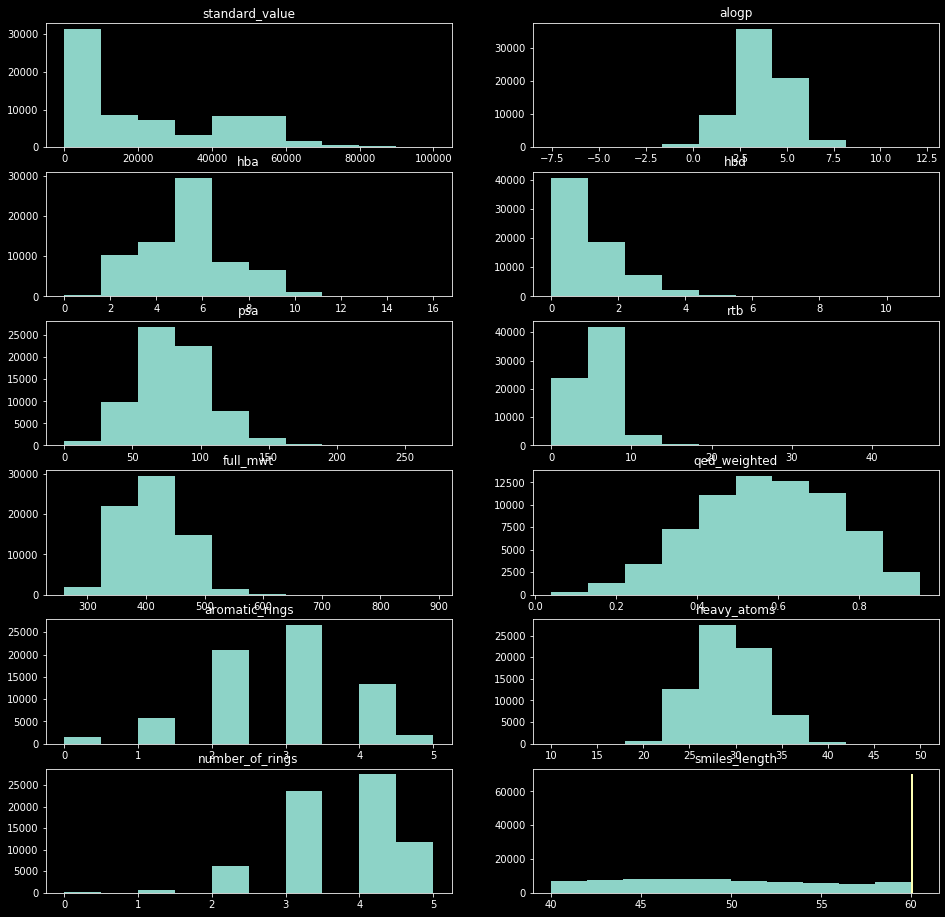

In [73]:
import psycopg2
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from numpy import random

from sklearn.preprocessing import StandardScaler

import os
os.chdir('/home/rafalb/work/molecules/moleculesStatic')


with open('molDataGroupedFinal.pckl', 'rb') as file:
    molDataGroupedChosen = pickle.load(file)

nSmilesCodes = 200000
mask = random.randint(0, molDataGroupedChosen.shape[0], size=nSmilesCodes)

staticFeatures = pd.DataFrame()
toBeAveraged = ['standard_value', 'alogp', 'hba', 'hbd', 'psa', 'rtb', 'full_mwt', 'qed_weighted']
for quantity in toBeAveraged:
    staticFeatures.loc[:, quantity] = (molDataGroupedChosen.loc[mask, (quantity, 'min')] + molDataGroupedChosen.loc[mask, (quantity, 'max')])/2
    staticFeatures.loc[:, quantity].astype(float)
toBeTaken = ['aromatic_rings', 'heavy_atoms']
for quantity in toBeTaken:
    staticFeatures.loc[:, quantity] = molDataGroupedChosen.loc[mask, (quantity, 'min')]
    staticFeatures.loc[:, quantity].astype(float)
staticFeatures.loc[:, 'number_of_rings'] = molDataGroupedChosen.loc[mask, 'numberOfRings'].astype(float)
#staticFeatures.loc[:, 'number_of_rings'] = staticFeatures.loc[:, 'number_of_rings'].astype(float)
#print(staticFeatures.head(2))

staticFeatures['full_mwt'] = staticFeatures.full_mwt.astype(float)
staticFeatures['qed_weighted'] = staticFeatures.qed_weighted.astype(float)
staticFeatures['aromatic_rings'] = staticFeatures.aromatic_rings.astype(float)
staticFeatures['smiles_length'] = molDataGroupedChosen.loc[staticFeatures.index, 'canonicalSmiles'].apply(lambda x: len(x))


# Remove rows with nans
staticFeatures = staticFeatures.dropna()

# Filter the smiles from given length range
staticFeatures = staticFeatures[(staticFeatures['smiles_length'] >= 40) & (staticFeatures['smiles_length'] <= 60)]

thres = 100000
print(staticFeatures[staticFeatures['standard_value'] < thres].shape[0] / staticFeatures['standard_value'].shape[0])

staticFeatures = staticFeatures[staticFeatures['standard_value'] < thres]

nFinalChoice = 70000
staticFeatures = staticFeatures.sample(nFinalChoice)

allDescriptors = ['standard_value', 'alogp', 'hba', 'hbd', 'psa', 'rtb', 'full_mwt', 'qed_weighted', 'aromatic_rings', 'heavy_atoms', 'number_of_rings', 'smiles_length']

plotIdx = 1
nRows = np.ceil(len(allDescriptors) / 2)
fig = plt.figure(figsize=(16, 16)) 
for quantity in allDescriptors:
    print(quantity)
    plt.subplot(nRows, 2, plotIdx)
    plt.hist(staticFeatures[~staticFeatures[quantity].isnull()][quantity], bins = 10)
    plt.title(quantity)
    plotIdx += 1

smilesCodes = molDataGroupedChosen.loc[staticFeatures.index, 'encodedSmiles']


maxlen = -1
for code in smilesCodes:
    if len(code) > maxlen:
        maxlen = len(code)
maxlen

minlen = 1e6
for code in smilesCodes:
    if len(code) < minlen:
        minlen = len(code)
minlen

def pad_smile(string, max_len, padding='right'):
    if len(string) <= max_len:
        if padding == 'right':
            return string + " " * (max_len - len(string))
        elif padding == 'left':
            return " " * (max_len - len(string)) + string
        elif padding == 'none':
            return string

smilesCodes = smilesCodes.apply(lambda x: pad_smile(x, max_len=maxlen, padding='right'))

chars = sorted(list(set(smilesCodes.str.cat(sep=''))))
print('total chars:', len(chars))
print(chars)
char2indices = dict((c, i) for i, c in enumerate(chars))
indices2char = dict((i, c) for i, c in enumerate(chars))

dynamicFeatures = np.zeros((len(smilesCodes), maxlen, len(chars)), dtype=np.float)
print(dynamicFeatures.shape)

for codeidx, code in enumerate(smilesCodes):
    for charidx, char in enumerate(code):
        dynamicFeatures[codeidx, charidx, char2indices[char]] = 1


sums = []
for idx in range(dynamicFeatures.shape[0]):
    sums.append(np.sum(dynamicFeatures[idx, :, :]))
plt.hist(sums)

# Choose some subset of dynamicFeatures
staticChosen = ['full_mwt', 'heavy_atoms', 'smiles_length']
scaler = StandardScaler()
scaler.fit(staticFeatures[staticChosen])

staticFeaturesStandard = scaler.transform(staticFeatures[staticChosen])

In [69]:
staticFeatures.head()

,standard_value,alogp,hba,hbd,psa,rtb,full_mwt,qed_weighted,aromatic_rings,heavy_atoms,number_of_rings,smiles_length
702216,20007.500,0.80,6.0,2.0,96.55,5.0,344.37,0.83,2.0,25.0,3.0,44
660891,17969.065,4.97,3.0,0.0,37.38,8.0,361.49,0.49,2.0,27.0,2.0,49
433803,47819.100,1.81,7.0,1.0,87.64,4.0,396.49,0.80,2.0,26.0,3.0,47
280645,44564.800,2.85,6.0,2.0,90.01,5.0,366.45,0.54,3.0,26.0,3.0,43
551980,45451.700,2.86,5.0,2.0,108.57,7.0,469.56,0.52,3.0,33.0,4.0,60


In [70]:
from keras.layers import LSTM, TimeDistributed, concatenate, Input, Dense, RepeatVector, Lambda
from keras.models import Model
from keras.activations import relu, sigmoid, tanh
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.optimizers import Adam, RMSprop
import keras.backend as K
from keras.utils import plot_model
from keras import losses
import numpy.random as rnd

def sampling(args):
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean=0 and std=1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

def prepare_model(static, dynamic, k, window, charsetLen, lr, lossFunction, showArch):
    input_dynamic = Input(shape=(window, charsetLen), name="input_dynamic")
    input_static = Input(shape=(static,), name="input_static")
    latent = Dense(k[0], activation=relu)(input_static)
    dense_h = Dense(k[0])(latent)
    dense_c = Dense(k[0])(latent)
    lstm_layer, state_h, state_c = LSTM(k[0], return_sequences=True, return_state=True)(input_dynamic,
                                                                                        initial_state=[dense_h,
                                                                                                       dense_c])

    for x in k[1:-1]:
        concat_h = concatenate([dense_h, state_h])
        dense_h = Dense(x)(concat_h)
        concat_c = concatenate([dense_c, state_c])
        dense_c = Dense(x)(concat_c)
        lstm_layer, state_h, state_c = LSTM(x, return_sequences=True, return_state=True)(lstm_layer,
                                                                                         initial_state=[dense_h,
                                                                                                        dense_c])
    x = k[-1]
    concat_h = concatenate([dense_h, state_h])
    dense_h = Dense(x)(concat_h)
    concat_c = concatenate([dense_c, state_c])
    dense_c = Dense(x)(concat_c)
    lstm_layer, state_h, state_c = LSTM(x, return_state=True)(lstm_layer, initial_state=[dense_h, dense_c])
    concat = concatenate([lstm_layer, latent])

    # autoencoder
    z_mean = Dense(x, name='z_mean')(concat)
    z_log_var = Dense(x, name='z_log_var')(concat)
    
    
    z = Lambda(sampling, output_shape=(x,), name='z')([z_mean, z_log_var])
    
    
    
    state_h = Dense(k[-2], activation=relu)(z)
    dense_h = Dense(k[-2], activation=relu)(z)
    state_c = Dense(k[-2], activation=relu)(z)
    dense_c = Dense(k[-2], activation=relu)(z)
    lstm_layer = RepeatVector(window)(z)

    for x in np.flip(k[:-1]):
        concat_h = concatenate([dense_h, state_h])
        dense_h = Dense(x)(concat_h)
        concat_c = concatenate([dense_c, state_c])
        dense_c = Dense(x)(concat_c)
        lstm_layer, state_h, state_c = LSTM(x, return_sequences=True, return_state=True)(lstm_layer,
                                                                                         initial_state=[dense_h,
                                                                                                        dense_c])

    #result_series = TimeDistributed(Dense(charsetLen))(lstm_layer)
    result_series = LSTM(charsetLen, return_sequences=True, activation='softmax')(lstm_layer)
    concat = concatenate([state_h, state_c])
    #result_sigmoid = Dense(static-3, activation=sigmoid)(concat)
    result_relu = Dense(static, activation=sigmoid)(concat)

    #model = Model(inputs=[input_dynamic, input_static], outputs=[result_series, result_sigmoid, result_relu])
    model = Model(inputs=[input_dynamic, input_static], outputs=[result_series, result_relu])
    optimizer = RMSprop(lr=lr)
    model.compile(optimizer=optimizer, loss=lossFunction, metrics=['binary_crossentropy', 'mean_absolute_error'])
    if (showArch):
        print(model.summary())
    return model



def prepareModelOnlyDynamic(dynamicDim, k, lr, lossFunction, showArch):
    input_dynamic = Input(shape=(dynamicDim[1], dynamicDim[2]), name="inputDynamic")
    lstm_layer, state_h, state_c = LSTM(k[0], return_sequences=True, return_state=True)(input_dynamic)

    for x in k[1:-1]:
        lstm_layer, state_h, state_c = LSTM(x, return_sequences=True, return_state=True)(lstm_layer)
        
    x = k[-1]

    lstm_layer, state_h, state_c = LSTM(x, return_state=True)(lstm_layer)

    # autoencoder
    z_mean = Dense(x, name='z_mean')(lstm_layer)
    z_log_var = Dense(x, name='z_log_var')(lstm_layer)
    
    z = Lambda(sampling, output_shape=(x,), name='z')([z_mean, z_log_var])
    
    lstm_layer = RepeatVector(dynamicDim[1])(z)

    for x in np.flip(k[:-1]):
        lstm_layer, state_h, state_c = LSTM(x, return_sequences=True, return_state=True)(lstm_layer)

    #result_series = TimeDistributed(Dense(charsetLen))(lstm_layer)
    result_series = LSTM(dynamicDim[2], return_sequences=True, activation='softmax')(lstm_layer)

    #model = Model(inputs=[input_dynamic, input_static], outputs=[result_series, result_sigmoid, result_relu])
    model = Model(inputs=[input_dynamic], outputs=[result_series])
    optimizer = RMSprop(lr=lr)
    model.compile(optimizer=optimizer, loss=lossFunction, metrics=['binary_crossentropy', 'mean_absolute_error'])
    if (showArch):
        print(model.summary())
    return model


def prepareModelDynamicStatic(dynamicDim, staticDim, k, lr, lossFunction, showArch):

    input_dynamic = Input(shape=(dynamicDim[1], dynamicDim[2]), name="inputDynamic")
    input_static = Input(shape=(staticDim[1],), name="inputStatic")

    latent = Dense(k[0], activation=relu)(input_static)
    dense_h = Dense(k[0])(latent)
    dense_c = Dense(k[0])(latent)
    
    lstm_layer, state_h, state_c = LSTM(k[0], return_sequences=True, return_state=True)(input_dynamic, initial_state=[dense_h, dense_c])

    for x in k[1:-1]:
        concat_h = concatenate([dense_h, state_h])
        dense_h = Dense(x)(concat_h)
        concat_c = concatenate([dense_c, state_c])
        dense_c = Dense(x)(concat_c)
        lstm_layer, state_h, state_c = LSTM(x, return_sequences=True, return_state=True)(lstm_layer, initial_state = [dense_h, dense_c])
        
    x = k[-1]
    concat_h = concatenate([dense_h, state_h])
    dense_h = Dense(x)(concat_h)
    concat_c = concatenate([dense_c, state_c])
    dense_c = Dense(x)(concat_c)
    lstm_layer, state_h, state_c = LSTM(x, return_state=True)(lstm_layer, initial_state=[dense_h, dense_c])
    concat = concatenate([lstm_layer, latent])


    #lstm_layer, state_h, state_c = LSTM(x, return_state=True)(lstm_layer)

    # autoencoder
    z_mean = Dense(x, name='z_mean')(concat)
    z_log_var = Dense(x, name='z_log_var')(concat)
    
    z = Lambda(sampling, output_shape=(x,), name='z')([z_mean, z_log_var])
    
    state_h = Dense(k[-2], activation=relu)(z)
    dense_h = Dense(k[-2], activation=relu)(z)
    state_c = Dense(k[-2], activation=relu)(z)
    dense_c = Dense(k[-2], activation=relu)(z)
    lstm_layer = RepeatVector(dynamicDim[1])(z)

    for x in np.flip(k[:-1]):
        lstm_layer, state_h, state_c = LSTM(x, return_sequences=True, return_state=True)(lstm_layer)

    #result_series = TimeDistributed(Dense(charsetLen))(lstm_layer)
    result_series = LSTM(dynamicDim[2], return_sequences=True, activation='softmax', name = 'outputDynamic')(lstm_layer)
    
    concat = concatenate([state_h, state_c])
    result_static = Dense(staticDim[1], activation=sigmoid, name = 'outputStatic')(concat)
    
    #model = Model(inputs=[input_dynamic, input_static], outputs=[result_series, result_sigmoid, result_relu])
    model = Model(inputs=[input_dynamic, input_static], outputs=[result_series, result_static])
    optimizer = RMSprop(lr=lr)
    model.compile(optimizer=optimizer, loss=lossFunction, metrics=['binary_crossentropy', 'mean_absolute_error'])
    if (showArch):
        print(model.summary())
    return model



def fit(staticFeatures, dynamicFeatures, model, step=1):
    #dynamic_data = np.empty((0, window, 1), np.float)
    #helper = []
    #for d in dynamic:
    #    new_data = rolling_window(d, window, step)
    #    helper.append(len(new_data))
    #    dynamic_data = np.append(dynamic_data, new_data, axis=0)
    #print(len(helper))
    #static_data = np.repeat(static, helper, axis=0)
    order = rnd.permutation(len(staticFeatures))

    early_stopping = EarlyStopping(monitor='val_loss', patience=5)
    bst_model_path = 'autoencoder.h5'
    checkpoint = ModelCheckpoint(bst_model_path, save_best_only=True, save_weights_only=True, monitor='val_loss')

    size = int(staticFeaturesSta.shape[0] * 0.9)
    training_dynamic, training_static = dynamicFeatures[order[:size]], staticFeatures[order[:size]]
    testing_dynamic, testing_static = dynamicFeatures[order[size:]], staticFeatures[order[size:]]
    print(training_dynamic.shape, training_static.shape)
    print(testing_dynamic.shape, testing_static.shape)
    model.fit([training_dynamic, training_static], 
              [training_dynamic, training_static],
                   epochs=10,
                   batch_size=64,
                   callbacks=[early_stopping, checkpoint],
                   validation_data=([testing_dynamic, testing_static], 
                                    [testing_dynamic, testing_static]))


def fitOnlyDynamic(dynamicFeatures, model, step=1):

    order = rnd.permutation(len(staticFeatures))

    early_stopping = EarlyStopping(monitor='val_loss', patience=5)
    bst_model_path = 'autoencoder.h5'
    checkpoint = ModelCheckpoint(bst_model_path, save_best_only=True, save_weights_only=True, monitor='val_loss')

    size = int(dynamicFeatures.shape[0] * 0.9)
    training_dynamic = dynamicFeatures[order[:size]]
    testing_dynamic = dynamicFeatures[order[size:]]
    print(training_dynamic.shape)
    print(testing_dynamic.shape)
    model.fit(training_dynamic,
              training_dynamic,
                   epochs=10,
                   batch_size=64,
                   callbacks=[early_stopping, checkpoint],
                   validation_data=(testing_dynamic, 
                                    testing_dynamic))

def fitDynamicStatic(dynamicFeatures, staticFeatures, model, modelFilePath, nEpoch, nBatch):
    order = rnd.permutation(len(staticFeatures))

    early_stopping = EarlyStopping(monitor='val_loss', patience=5)

    checkpoint = ModelCheckpoint(modelFilePath, save_best_only=True, save_weights_only=True, monitor='val_loss')

    size = int(staticFeatures.shape[0] * 0.9)
    training_dynamic, training_static = dynamicFeatures[order[:size]], staticFeatures[order[:size]]
    testing_dynamic, testing_static = dynamicFeatures[order[size:]], staticFeatures[order[size:]]
    print(training_dynamic.shape, training_static.shape)
    print(testing_dynamic.shape, testing_static.shape)
    model.fit([training_dynamic, training_static], 
              [training_dynamic, training_static],
              epochs=nEpoch,
              batch_size=nBatch,
              callbacks=[early_stopping, checkpoint],
              validation_data=([testing_dynamic, testing_static], 
                                    [testing_dynamic, testing_static]))

In [71]:
lr = 0.001
model = prepareModelDynamicStatic(dynamicFeatures.shape, staticFeaturesStandard.shape, [64,64,32], lr, ['binary_crossentropy', 'mean_absolute_error'], True)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputStatic (InputLayer)        (None, 3)            0                                            
__________________________________________________________________________________________________
dense_45 (Dense)                (None, 64)           256         inputStatic[0][0]                
__________________________________________________________________________________________________
inputDynamic (InputLayer)       (None, 60, 27)       0                                            
__________________________________________________________________________________________________
dense_46 (Dense)                (None, 64)           4160        dense_45[0][0]                   
__________________________________________________________________________________________________
dense_47 (

In [66]:
fitDynamicStatic(dynamicFeatures, staticFeaturesStandard, model, 'dynamicStatic_20191026.h5', 2, 128)

(97709, 60, 27) (97709, 3)
(10857, 60, 27) (10857, 3)
Train on 97709 samples, validate on 10857 samples
Epoch 1/2
 4352/97709 [>.............................] - ETA: 6:12 - loss: 0.8141 - outputDynamic_loss: 0.1497 - outputStatic_loss: 0.6644 - outputDynamic_binary_crossentropy: 0.1497 - outputDynamic_mean_absolute_error: 0.0517 - outputStatic_binary_crossentropy: -2.8847 - outputStatic_mean_absolute_error: 0.6644

KeyboardInterrupt: 

In [14]:
staticFeatures[staticFeatures['hba'].isnull()]

array([[-1.03868845,  0.34328506],
       [ 0.9111424 ,  0.34328506],
       [-1.03868845,  0.34328506],
       ...,
       [-2.01360387, -0.39666957],
       [ 1.39860012,  0.34328506],
       [ 0.9111424 , -0.39666957]])

In [40]:
staticFeatures[['hba', 'hbd']].isnull().sum()

(42343, 141, 27) (42343, 2)
(4705, 141, 27) (4705, 2)
Train on 42343 samples, validate on 4705 samples
Epoch 1/10
 9280/42343 [=====>........................] - ETA: 8:16 - loss: 0.6708 - lstm_41_loss: 0.0740 - dense_46_loss: 0.5968 - lstm_41_binary_crossentropy: 0.0740 - lstm_41_mean_absolute_error: 0.0281 - dense_46_binary_crossentropy: -3.6844 - dense_46_mean_absolute_error: 0.5968

KeyboardInterrupt: 

In [19]:
fitDynamicStatic(dynamicFeatures, staticFeaturesStandard, model)

ImportError: Failed to import `pydot`. Please install `pydot`. For example with `pip install pydot`.

In [16]:
staticFeatures[['hba', 'hbd']].isnull().sum()

In [ ]:
from keras.utils import plot_model
plot_model(model)

In [ ]:
staticFeatures[staticFeatures['hba'].isnull()]

In [ ]:
lr = 0.001
model = prepare_model(staticFeaturesStandard.shape[1], 1, [64,64], dynamicFeatures.shape[1], dynamicFeatures.shape[2], lr, ['binary_crossentropy', 'mean_absolute_error'], True)

In [19]:
lr = 0.001
model = prepareModelOnlyDynamic(dynamicFeatures.shape, [64,64], lr, 'binary_crossentropy', True)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputDynamic (InputLayer)       (None, 149, 28)      0                                            
__________________________________________________________________________________________________
lstm_25 (LSTM)                  [(None, 149, 64), (N 23808       inputDynamic[0][0]               
__________________________________________________________________________________________________
lstm_26 (LSTM)                  [(None, 64), (None,  33024       lstm_25[0][0]                    
__________________________________________________________________________________________________
z_mean (Dense)                  (None, 64)           4160        lstm_26[0][0]                    
__________________________________________________________________________________________________
z_log_var 

In [3]:
lr = 0.001
model = prepare_model(staticFeaturesStandard.shape[1], 1, [64,64], dynamicFeatures.shape[1], dynamicFeatures.shape[2], lr, ['binary_crossentropy', 'mean_absolute_error'], True)

W1024 23:42:22.325972 140299345049408 deprecation_wrapper.py:119] From /home/rafalb/miniconda3/envs/tensorflow/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W1024 23:42:22.340703 140299345049408 deprecation_wrapper.py:119] From /home/rafalb/miniconda3/envs/tensorflow/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W1024 23:42:22.341521 140299345049408 deprecation_wrapper.py:119] From /home/rafalb/miniconda3/envs/tensorflow/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W1024 23:42:22.641961 140299345049408 deprecation_wrapper.py:119] From /home/rafalb/miniconda3/envs/tensorflow/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4115: The name tf.rand

In [ ]:
fit(staticFeaturesStandard, dynamicFeatures, model)

In [21]:
fitOnlyDynamic(dynamicFeatures, model)

(42444, 149, 28)
(4717, 149, 28)
Train on 42444 samples, validate on 4717 samples
Epoch 1/10
42444/42444 [==============================] - 447s 11ms/step - loss: 0.0512 - binary_crossentropy: 0.0512 - mean_absolute_error: 0.0222 - val_loss: 0.0463 - val_binary_crossentropy: 0.0463 - val_mean_absolute_error: 0.0204
Epoch 2/10
42444/42444 [==============================] - 444s 10ms/step - loss: 0.0450 - binary_crossentropy: 0.0450 - mean_absolute_error: 0.0209 - val_loss: 0.0449 - val_binary_crossentropy: 0.0449 - val_mean_absolute_error: 0.0228
Epoch 3/10
42444/42444 [==============================] - 445s 10ms/step - loss: 0.0421 - binary_crossentropy: 0.0421 - mean_absolute_error: 0.0199 - val_loss: 0.0399 - val_binary_crossentropy: 0.0399 - val_mean_absolute_error: 0.0189
Epoch 4/10
42444/42444 [==============================] - 444s 10ms/step - loss: 0.0404 - binary_crossentropy: 0.0404 - mean_absolute_error: 0.0192 - val_loss: 0.0402 - val_binary_crossentropy: 0.0402 - val_mean_a